In [271]:

import pandas as pd
import psycopg2
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
import dotenv
import os

dotenv.load_dotenv()

# PG_PASSWORD = "_KjE6\2_JX0UGTJdZYl"
# PG_USER = "busit_87"
# PG_HOST = "fuji.ucll.be"
# PG_PORT = "52425"
# PG_DATABASE = "international_week"

# PG_PASSWORD = os.getenv("PG_PASSWORD")
# PG_USER = os.getenv("PG_USER")
# PG_HOST = os.getenv("PG_HOST")
# PG_PORT = os.getenv("PG_PORT")
# PG_DATABASE = os.getenv("PG_DB")

PG_PASSWORD = os.getenv("PG_PASSWORD", "_KjE6\\2_JX0UGTJdZYl")
PG_USER = os.getenv("PG_USER", "busit_87")
PG_HOST = os.getenv("PG_HOST", "fuji.ucll.be")
PG_PORT = os.getenv("PG_PORT", "52425")
PG_DATABASE = os.getenv("PG_DB", "international_week")

# Database connection parameters
import psycopg2
import os

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="allow",
)

# # Query to fetch tracking data
# query = """
# SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
# FROM player_tracking pt
# JOIN players p ON pt.player_id = p.player_id
# JOIN teams t ON p.team_id = t.team_id
# WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg';
# """
# tracking_df = pd.read_sql_query(query, conn)
# tracking_df.head()

In [272]:
query = """
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id
    FROM spadl_actions a
    WHERE a.game_id = '5uts2s7fl98clqz8uymaazehg'
),

possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM action_changes
),

possession_groups AS (
    SELECT
        *,
        SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_id
    FROM possession_markers
),

possession_start_times AS (
    SELECT
        possession_id,
        MIN(seconds) AS possession_start_time
    FROM possession_groups
    GROUP BY possession_id
)

SELECT pg.*
FROM possession_groups pg
JOIN possession_start_times pst
ON pg.possession_id = pst.possession_id
WHERE pg.seconds - pst.possession_start_time <= 5;

"""

In [273]:
# WITH action_changes AS (
#     SELECT
#         a.*,
#         LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id
#     FROM spadl_actions a
#     WHERE a.game_id = '5uts2s7fl98clqz8uymaazehg'
# ),

# possession_markers AS (
#     SELECT
#         *,
#         CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
#     FROM action_changes
# ),

# possession_groups AS (
#     SELECT
#         *,
#         SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_id
#     FROM possession_markers
# ),

# possession_start_times AS (
#     SELECT
#         possession_id,
#         MIN(seconds) AS possession_start_time
#     FROM possession_groups
#     GROUP BY possession_id
# )

# SELECT pg.*
# FROM possession_groups pg
# JOIN possession_start_times pst
# ON pg.possession_id = pst.possession_id
# WHERE pg.seconds - pst.possession_start_time <= 5;
def get_spadel_actions(game_id):
    query = f"""
    WITH action_changes AS (
        SELECT
            a.*,
            LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id
        FROM spadl_actions a
        WHERE a.game_id = '{game_id}'
    ),

    possession_markers AS (
        SELECT
            *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
        FROM action_changes
    ),

    possession_groups AS (
        SELECT
            *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_id
        FROM possession_markers
    ),

    possession_start_times AS (
        SELECT
            possession_id,
            MIN(seconds) AS possession_start_time
        FROM possession_groups
        GROUP BY possession_id
    )

    SELECT pg.*
    FROM possession_groups pg
    JOIN possession_start_times pst ON pg.possession_id = pst.possession_id
    WHERE pg.seconds - pst.possession_start_time <= 5;
    """
    return pd.read_sql_query(query, conn)

spadel_df = pd.read_sql_query(query, conn)
spadel_df.head()

,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,action_type,result,bodypart,prev_team_id,is_new_possession,possession_id
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,60gs7lod7de72ypcs6qfup8q2,8y3iucyxguipljcmf87a11bk9,52.500,34.000,43.365,36.312,0,1,0,None,1,1
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,43.365,36.312,48.720,34.680,21,1,0,8y3iucyxguipljcmf87a11bk9,0,1
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,48.720,34.680,45.150,50.184,0,1,0,8y3iucyxguipljcmf87a11bk9,0,1
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,8fs5klbsyx06c5ds9s1i3xu96,8y3iucyxguipljcmf87a11bk9,46.200,48.008,39.270,63.376,0,1,0,8y3iucyxguipljcmf87a11bk9,0,1
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,39.270,63.376,42.945,63.920,21,1,0,8y3iucyxguipljcmf87a11bk9,0,1


In [274]:

def get_tracking_players(game_id):
    query = f"""
    select * from player_tracking as pt
    inner join players as p on pt.player_id = p.player_id
    WHERE pt.game_id = '{game_id}'
    order by pt.timestamp asc
    """
    tracking_df = pd.read_sql_query(query, conn)
    # tracking_df["timestamp"] = pd.to_timedelta(tracking_df["timestamp"]).dt.total_seconds()
    return tracking_df

tracking_df = get_tracking_players("5uts2s7fl98clqz8uymaazehg")
tracking_df.head()

,id,game_id,frame_id,timestamp,period_id,player_id,x,y,player_id,player_name,team_id,jersey_number
0,1834184,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,863wevd1kdzq5sd7qpmhr4lqs,45.650492,87.893418,863wevd1kdzq5sd7qpmhr4lqs,F. Ferraro,4dtif7outbuivua8umbwegoo5,88
1,1834185,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,18pgjfpl9s8qy32mblzygsyc5,55.737377,42.366909,18pgjfpl9s8qy32mblzygsyc5,S. Kums,8y3iucyxguipljcmf87a11bk9,24
2,1834186,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,7ld784sfqk29tlvpes2f4vcru,49.225902,69.955282,7ld784sfqk29tlvpes2f4vcru,D. Yokota,8y3iucyxguipljcmf87a11bk9,14
3,1834194,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,be0ws51ws5cm9wzmcp3ozmklx,93.945055,49.758689,be0ws51ws5cm9wzmcp3ozmklx,D. Roef,8y3iucyxguipljcmf87a11bk9,33
4,1834187,5uts2s7fl98clqz8uymaazehg,1722802500280,00:00:00.280000,2,2961iy0sg9zmy0r6fzbr2dmg9,49.503279,2.611582,2961iy0sg9zmy0r6fzbr2dmg9,D. Hrnčár,4dtif7outbuivua8umbwegoo5,20


In [275]:
import pandas as pd

# Assuming spadel_df and tracking_df are already loaded
spadel_timings = sorted(set(spadel_df['seconds'].tolist()))

# Convert tracking timestamp strings to seconds and scale by dividing by 10
tracking_df['converted_tracking_timings'] = tracking_df['timestamp'].apply(
    lambda ts: round(pd.to_timedelta(ts).total_seconds() / 10, 1)
)

# Optionally, filter so that only rows with converted timing present in spadel_timings remain.
tracking_df = tracking_df[tracking_df['converted_tracking_timings'].isin(spadel_timings)]

# Also, if needed, sort and remove duplicate converted timings (if you use them elsewhere)
converted_tracking_timings = sorted(set(tracking_df['converted_tracking_timings'].tolist()))

print(f"SPADL Timings: {spadel_timings}")
print(f"Converted Tracking Timings: {converted_tracking_timings}")


SPADL Timings: [0.0, 0.5, 1.0, 2.0, 4.0, 5.0, 7.0, 9.0, 12.0, 14.0, 15.5, 17.0, 18.0, 19.0, 23.0, 23.5, 24.0, 26.0, 27.0, 29.5, 32.0, 33.0, 33.5, 34.0, 35.0, 36.0, 38.0, 52.0, 53.0, 55.0, 60.0, 63.0, 64.0, 64.5, 65.0, 65.5, 66.0, 68.0, 68.5, 69.0, 69.5, 70.0, 73.0, 79.0, 80.0, 81.0, 90.0, 98.0, 98.5, 99.0, 99.5, 100.0, 101.5, 103.0, 104.5, 106.0, 107.0, 110.0, 113.0, 125.0, 127.5, 130.0, 133.0, 135.0, 143.0, 145.0, 146.0, 150.0, 151.0, 153.0, 154.0, 155.0, 155.5, 156.0, 157.0, 158.0, 160.0, 161.0, 164.0, 172.0, 173.0, 175.0, 184.0, 186.0, 189.0, 199.0, 200.0, 205.0, 209.0, 212.0, 213.0, 214.0, 228.0, 237.0, 240.0, 241.0, 242.5, 244.0, 245.0, 250.0, 251.0, 251.5, 252.0, 255.0, 256.0, 259.0, 260.0, 264.5, 269.0, 278.0, 279.5, 281.0, 282.0, 283.0, 285.0, 285.5, 286.0, 288.0, 290.0, 292.0, 314.0, 315.0, 316.0, 319.0, 319.5, 320.0, 320.5, 321.0, 344.0, 346.0, 347.0, 351.0, 356.0, 362.0, 364.5, 367.0, 369.0, 370.0, 372.0, 373.0, 391.0, 392.5, 394.0, 395.0, 396.0, 397.0, 399.0, 400.0, 403.0, 

In [276]:
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib as mpl

# Output folder for frames
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Step 1: **Get all unique teams and assign fixed colors**
team_names = tracking_df['team_id'].unique()
fixed_colors = list(mpl.colors.TABLEAU_COLORS.values())  # 10 colors available
color_map = {team: fixed_colors[i % len(fixed_colors)] for i, team in enumerate(sorted(team_names))}

def plot_tracking_data(tracking_data, frame_id):
    """Generate and save each frame as an image with consistent team colors."""
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta', stripe=True, pitch_length=105, pitch_width=68)
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Use the precomputed converted timing value
    timestamp = tracking_data['converted_tracking_timings'].iloc[0]
    
    # Loop through each row and plot
    for _, row in tracking_data.iterrows():
        x, y = row['x'], row['y']
        team_name = row['team_id']
        
        # Plot the ball differently
        if row['player_name'] == 'Ball':
            pitch.scatter(x, y, s=90, color='yellow', ax=ax)
        else:
            pitch.scatter(x, y, s=100, color=color_map[team_name], ax=ax)
        
        # Add player names (excluding the ball)
        if row['player_name'] != 'Ball':
            ax.text(x + 2, y + 2, f"{row['player_name']} ({row['jersey_number']})", fontsize=8)
    
    ax.set_title(f'Frame {frame_id} - Timestamp: {timestamp}', fontsize=16)
    plt.tight_layout()
    
    # Save frame as PNG
    frame_filename = os.path.join(output_dir, f"frame_{frame_id}.png")
    plt.savefig(frame_filename, dpi=100)
    plt.close(fig)

# Generate frames (for example, limit to the first 200 frames)
unique_frames = tracking_df['frame_id'].unique()
for frame_id in unique_frames[:5]:
    frame_data = tracking_df[tracking_df['frame_id'] == frame_id]
    # plot_tracking_data(frame_data, frame_id)
    pass

print("Frames saved! Go create animation.")


Frames saved! Go create animation.


In [277]:
import numpy as np
import seaborn as sns

def plot_heatmap_per_frame(tracking_data, frame_id):
    """Generate and save a heatmap for each row of tracking data in a frame."""
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta', stripe=True, pitch_length=105, pitch_width=68)
    fig, ax = pitch.draw(figsize=(12, 8))

    # Use the precomputed converted timing value
    timestamp = tracking_data['converted_tracking_timings'].iloc[0]

    # Extract x, y positions for all players in the current frame
    x_positions = tracking_data['x'].values
    y_positions = tracking_data['y'].values
    
    # Create a heatmap using kernel density estimation (KDE)
    sns.kdeplot(x=x_positions, y=y_positions, shade=True, cmap="Reds", alpha=0.6, ax=ax, bw_adjust=0.5)
    
    ax.set_title(f'Heatmap {frame_id} - Timestamp: {timestamp}', fontsize=16)
    plt.tight_layout()

    # Save the heatmap frame as PNG
    heatmap_filename = os.path.join(output_dir, f"heatmap_frame_{frame_id}.png")
    plt.savefig(heatmap_filename, dpi=100)
    plt.close(fig)

# Generate heatmap for each frame (for example, limit to the first 200 frames)
unique_frames = tracking_df['frame_id'].unique()
for frame_id in unique_frames[:150]:
    frame_data = tracking_df[tracking_df['frame_id'] == frame_id]
    # plot_heatmap_per_frame(frame_data, frame_id)
    pass

print("Heatmaps saved! You can create an animation now.")


Heatmaps saved! You can create an animation now.


In [ ]:
def complexDfQuery(game_id, our_team, opponent_team, conn):
    complexQuery = f"""
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM public.spadl_actions a
    WHERE a.game_id = '{game_id}'
),
possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM action_changes
),
possession_groups AS (
    SELECT
        *,
        SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
    FROM possession_markers
),
possession_changes AS (
    SELECT
        *,
        CASE 
            WHEN prev_team_id = '{our_team}' AND team_id = '{opponent_team}' THEN 'A to B'
            WHEN prev_team_id = '{opponent_team}' AND team_id = '{our_team}' THEN 'B to A'
            ELSE 'No Change'
        END AS possession_change
    FROM possession_groups
),
count_rows_in_possession_group AS (
    SELECT
        *,
        COUNT(*) OVER (PARTITION BY possession_group ORDER BY period_id, seconds, id) AS rows_in_possession_group
    FROM possession_changes
),
initial_value_per_group AS (
    SELECT
        possession_group,
        MIN(seconds) AS initial_seconds
    FROM count_rows_in_possession_group
    GROUP BY possession_group
),
possession_stats AS (
    SELECT
        possession_group,
        team_id,
        COUNT(*) AS action_count,
        MAX(id) AS last_action_id
    FROM count_rows_in_possession_group
    GROUP BY possession_group, team_id
),
final_query AS (
    SELECT
        c.*, 
        (c.seconds - i.initial_seconds) AS seconds_difference,
        ABS(c.start_x - c.end_x) AS action_distance
    FROM count_rows_in_possession_group c
    JOIN initial_value_per_group i
      ON c.possession_group = i.possession_group
),
start_with_ball_table AS (
    SELECT *,
        CASE 
            WHEN FIRST_VALUE(prev_team_id) OVER (PARTITION BY possession_group ORDER BY id) IS NULL 
                 AND FIRST_VALUE(end_x) OVER (PARTITION BY possession_group ORDER BY id) < 52.5
            THEN 'LEFT_SIDE' 
            ELSE 'RIGHT_SIDE' 
        END AS start_with_ball
    FROM final_query
),
start_with_period AS (
    SELECT *,
        CASE 
            WHEN start_with_ball = 'LEFT_SIDE' AND period_id = 2 THEN 'RIGHT_SIDE' 
            WHEN start_with_ball = 'RIGHT_SIDE' AND period_id = 2 THEN 'LEFT_SIDE' 
            WHEN start_with_ball = 'LEFT_SIDE' AND period_id = 1 THEN 'LEFT_SIDE' 
            WHEN start_with_ball = 'RIGHT_SIDE' AND period_id = 1 THEN 'RIGHT_SIDE' 
        END AS update_start_with_ball
    FROM start_with_ball_table
),
isgoal AS (
    SELECT *,
        CASE 
            WHEN start_x < end_x AND update_start_with_ball = 'RIGHT_SIDE' THEN 'FORWARD'
            WHEN start_x > end_x AND update_start_with_ball = 'RIGHT_SIDE' THEN 'BACKWARD'
            WHEN start_x < end_x AND update_start_with_ball = 'LEFT_SIDE' THEN 'BACKWARD'
            WHEN start_x > end_x AND update_start_with_ball = 'LEFT_SIDE' THEN 'FORWARD'
            ELSE NULL
        END AS ballMoveDirection,
        CASE
            WHEN action_type = '10' AND result = '1' THEN '1'
            ELSE '0'
        END AS isGoal
    FROM start_with_period
    WHERE team_id = '{our_team}'
      AND possession_group IN (
          SELECT possession_group FROM possession_stats WHERE action_count >= 3
      )
),
goal_possession_groups AS (
    SELECT DISTINCT possession_group
    FROM isgoal
    WHERE isGoal = '1'
),
finale AS (
    SELECT 
        g.*,
        CASE 
            WHEN g.possession_group IN (SELECT possession_group FROM goal_possession_groups) THEN '1'
            ELSE g.isGoal
        END AS sequenceIsGoal
    FROM isgoal g
),
ballPitchPosition AS (
    SELECT d.*,
        CASE
            WHEN start_x >= 0 AND start_x < 35 THEN 'LEFT_SIDE'
            WHEN start_x >= 35 AND start_x < 70 THEN 'MIDDLE'
            WHEN start_x >= 70 AND start_x < 105 THEN 'RIGHT_SIDE'
            ELSE NULL
        END AS actionStartPitch
    FROM finale d
),
possessionGroupActionStartPitch AS (
    SELECT b.*,
           FIRST_VALUE(actionStartPitch) OVER (PARTITION BY possession_group ORDER BY id) AS possessionGroupActionStartPitch
    FROM ballPitchPosition b
),
isStartPossessionInTeamPitch AS (
    SELECT p.*,
        CASE 
            WHEN possessionGroupActionStartPitch = 'RIGHT_SIDE' AND update_start_with_ball = 'LEFT_SIDE' THEN '3'
            WHEN possessionGroupActionStartPitch = 'LEFT_SIDE' AND update_start_with_ball = 'RIGHT_SIDE' THEN '3'
            WHEN possessionGroupActionStartPitch = 'MIDDLE' THEN '2'
            WHEN possessionGroupActionStartPitch = 'RIGHT_SIDE' AND update_start_with_ball = 'RIGHT_SIDE' THEN '1'
            WHEN possessionGroupActionStartPitch = 'LEFT_SIDE' AND update_start_with_ball = 'LEFT_SIDE' THEN '1'
            ELSE NULL
        END AS isPossessionInTeamPitch
    FROM possessionGroupActionStartPitch p
)
SELECT * 
FROM isStartPossessionInTeamPitch
ORDER BY possession_group, rows_in_possession_group
"""

    return pd.read_sql_query(complexQuery, conn)

complexDf = complexDfQuery("5uts2s7fl98clqz8uymaazehg", "8y3iucyxguipljcmf87a11bk9", "4dtif7outbuivua8umbwegoo5", conn)
complexDf.to_csv('output.csv', index=False)
complexDf = complexDf.drop(columns=["start_with_ball"])
complexDf = complexDf.rename(columns={"update_start_with_ball": "start_with_ball"})

def getTeams():
    teamsQuery = """
    SELECT * FROM teams
    """
    return pd.read_sql_query(teamsQuery, conn)


teams = getTeams()

def getPlayers():
    playersQuery = """
    SELECT * FROM players
    """
    return pd.read_sql_query(playersQuery, conn)

players = getPlayers()
complexDf['player_id'] = complexDf['player_id'].replace(players.set_index('player_id')['player_name'].to_dict()) 
complexDf = complexDf.rename(columns={"player_id": "player_name"})

complexDf

complexDf['team_id'] = complexDf['team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
complexDf['prev_team_id'] = complexDf['prev_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
complexDf['next_team_id'] = complexDf['next_team_id'].replace(teams.set_index('team_id')['team_name'].to_dict())
complexDf = complexDf.rename(columns={"team_id": "team_name", "prev_team_id": "previous_team_name", "next_team_id": "next_team_name"})

complexDf.head(10)

,id,game_id,period_id,seconds,player_name,team_name,start_x,start_y,end_x,end_y,action_type,result,bodypart,previous_team_name,next_team_name,is_new_possession,possession_group,possession_change,rows_in_possession_group,seconds_difference,action_distance,start_with_ball,ballmovedirection,isgoal,sequenceisgoal,actionstartpitch,possessiongroupactionstartpitch,ispossessioninteampitch
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,A. Guðjohnsen,Gent,52.500,34.000,43.365,36.312,0,1,0,None,Gent,1,1,No Change,1,0.0,9.135,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,S. Kums,Gent,43.365,36.312,48.720,34.680,21,1,0,Gent,Gent,0,1,No Change,2,0.5,5.355,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,S. Kums,Gent,48.720,34.680,45.150,50.184,0,1,0,Gent,Gent,0,1,No Change,3,1.0,3.570,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,Hong Hyun-Seok,Gent,46.200,48.008,39.270,63.376,0,1,0,Gent,Gent,0,1,No Change,4,4.0,6.930,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,A. Brown,Gent,39.270,63.376,42.945,63.920,21,1,0,Gent,Gent,0,1,No Change,5,5.0,3.675,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
5,25139,5uts2s7fl98clqz8uymaazehg,1,6.0,A. Brown,Gent,42.945,63.920,28.665,51.068,0,1,0,Gent,Gent,0,1,No Change,6,6.0,14.280,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
6,25140,5uts2s7fl98clqz8uymaazehg,1,16.0,S. Mitrović,Gent,39.375,34.544,45.675,34.408,0,1,0,Gent,Gent,0,1,No Change,7,16.0,6.300,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
7,25141,5uts2s7fl98clqz8uymaazehg,1,16.5,M. Delorge,Gent,45.675,34.408,47.145,29.444,21,1,0,Gent,Gent,0,1,No Change,8,16.5,1.470,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
8,25142,5uts2s7fl98clqz8uymaazehg,1,17.0,M. Delorge,Gent,47.145,29.444,33.390,48.212,0,1,0,Gent,Gent,0,1,No Change,9,17.0,13.755,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
9,25143,5uts2s7fl98clqz8uymaazehg,1,18.0,S. Mitrović,Gent,33.390,48.212,39.480,36.720,21,1,0,Gent,Gent,0,1,No Change,10,18.0,6.090,LEFT_SIDE,BACKWARD,0,0,LEFT_SIDE,MIDDLE,2


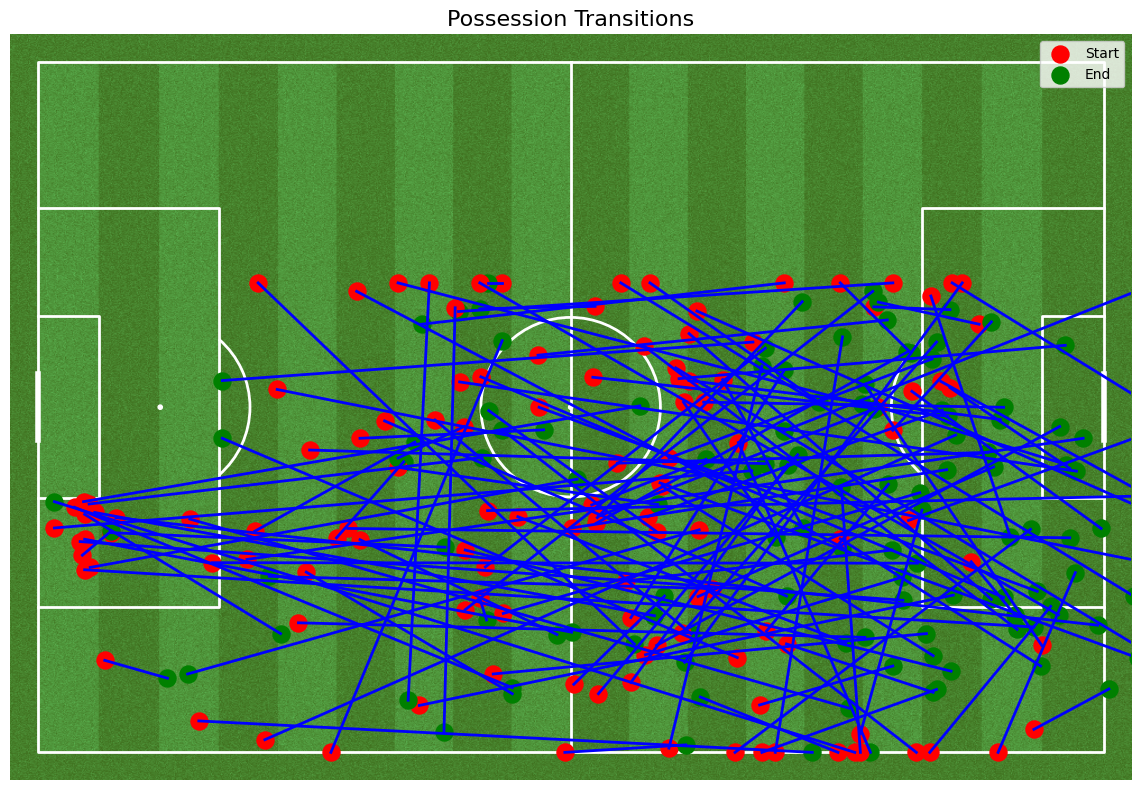

In [279]:

df = complexDf.copy()

# Filter rows where possession changes
possession_changes = df[df['is_new_possession'] == 1]

# Track player movements from the start to the end of possession
possession_groups = df.groupby('possession_group').agg({
    'start_x': 'first',
    'start_y': 'first',
    'end_x': 'last',
    'end_y': 'last',
    'seconds': 'max',
    'team_id': 'first',
    'possession_change': 'last',
}).reset_index()


# Create a soccer pitch for visualization
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white', stripe=True, pitch_length=105, pitch_width=68)

fig, ax = pitch.draw(figsize=(12, 8))

# Loop through each possession group
for idx, row in possession_groups.iterrows():
    start_x, start_y = row['start_x'], row['start_y']
    end_x, end_y = row['end_x'], row['end_y']
    team_id = row['team_id']

    # Visualize the transition (from start to end)
    pitch.plot([start_x, end_x], [start_y, end_y], ax=ax, color='blue', lw=2)

    # Mark the start and end points
    pitch.scatter(start_x, start_y, s=150, color='red', ax=ax, label='Start' if idx == 0 else "")
    pitch.scatter(end_x, end_y, s=150, color='green', ax=ax, label='End' if idx == 0 else "")

# Add a title
ax.set_title(f'Possession Transitions', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


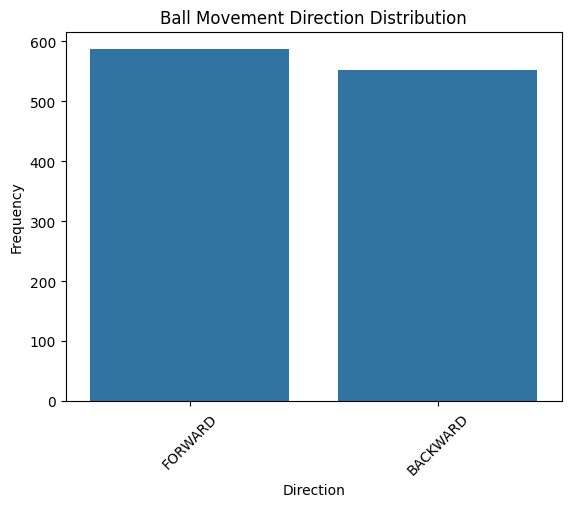

In [280]:
# Get the distribution of ball directions
ball_direction_counts = df['ballmovedirection'].value_counts()

# Plot the ball direction distribution
sns.barplot(x=ball_direction_counts.index, y=ball_direction_counts.values)
plt.title('Ball Movement Direction Distribution')
plt.ylabel('Frequency')
plt.xlabel('Direction')
plt.xticks(rotation=45)
plt.show()


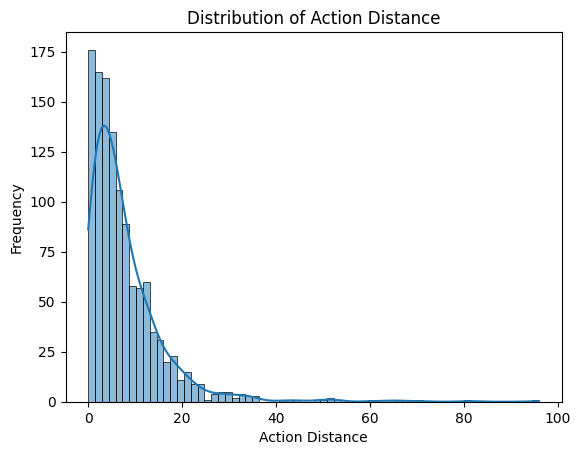

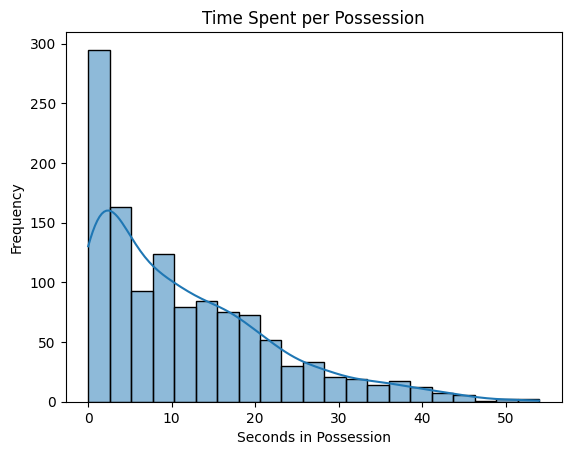

In [281]:
# Plotting action distances
sns.histplot(df['action_distance'], kde=True)
plt.title('Distribution of Action Distance')
plt.xlabel('Action Distance')
plt.ylabel('Frequency')
plt.show()

# Plotting time spent in each possession group
sns.histplot(df['seconds_difference'], kde=True)
plt.title('Time Spent per Possession')
plt.xlabel('Seconds in Possession')
plt.ylabel('Frequency')
plt.show()


In [282]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Assuming complexDf is your dataframe already loaded
# We'll select a set of features based on your columns.
# Feel free to add or remove features depending on your analysis.
features = [
    'start_x', 
    'start_y', 
    'end_x', 
    'end_y', 
    'seconds_difference', 
    'action_distance',
    'period_id',
    'ballmovedirection',  # categorical: e.g. FORWARD/BACKWARD
    'possession_change',  # categorical: e.g. 'A to B', 'B to A', 'No Change'
    'start_with_ball'     # categorical: e.g. LEFT_SIDE/RIGHT_SIDE
]
target = 'isgoal'  # your binary outcome column

# Prepare feature matrix X and target vector y.
X = complexDf[features]
y = complexDf[target].astype(int)

# Define which features are numeric and which are categorical.
num_features = ['start_x', 'start_y', 'end_x', 'end_y', 'seconds_difference', 'action_distance', 'period_id']
cat_features = ['ballmovedirection', 'possession_change', 'start_with_ball']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a preprocessor for numeric and categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Create a pipeline with preprocessing and logistic regression.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model.
model_pipeline.fit(X_train, y_train)

# Predict on the test set.
y_pred = model_pipeline.predict(X_test)

# Output the classification report.
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       238
           1       0.00      0.00      0.00         3

    accuracy                           0.99       241
   macro avg       0.49      0.50      0.50       241
weighted avg       0.98      0.99      0.98       241



In [283]:

def count_passes(game_id, our_team, opponent_team, conn):
    query = f"""
    WITH action_changes AS (
        SELECT
            a.*,
            LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
            LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
        FROM
            public.spadl_actions a
        WHERE
            a.game_id = '{game_id}'  
    ),
    possession_markers AS (
        SELECT
            *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
        FROM
            action_changes
    ),
    possession_groups AS (
        SELECT
            *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
        FROM
            possession_markers
    ),
    possession_changes AS (
        SELECT
            *,
            CASE 
                WHEN prev_team_id = '{opponent_team}' AND team_id = '{our_team}' THEN 'Defence to Attack'
                WHEN prev_team_id = '{our_team}' AND team_id = '{opponent_team}' THEN 'Attack to Defence'
                ELSE 'No Change'
            END AS possession_change
        FROM
            possession_groups
    ),
    count_rows_in_possession_group AS (
        SELECT
            *,
            COUNT(*) OVER (PARTITION BY possession_group ORDER BY period_id, seconds, id) AS rows_in_possession_group
        FROM
            possession_changes
    ),
    initial_value_per_group AS (
        SELECT
            possession_group,
            MIN(seconds) AS initial_seconds
        FROM
            count_rows_in_possession_group
        GROUP BY
            possession_group
    ),
    possession_stats AS (
        SELECT
            possession_group,
            team_id,
            COUNT(*) AS action_count,
            MAX(id) AS last_action_id
        FROM
            count_rows_in_possession_group
        GROUP BY
            possession_group, team_id
    ),
    final_query AS (
        SELECT
            c.*, 
            (c.seconds - i.initial_seconds) AS seconds_difference
        FROM
            count_rows_in_possession_group c
        JOIN 
            initial_value_per_group i
        ON 
            c.possession_group = i.possession_group
    )

    SELECT count(*)
    FROM final_query
    WHERE seconds_difference <= 5 
    AND action_type IN ('0')
    AND team_id = '{our_team}'  -- to know what it's the POV
    AND possession_group IN (
        SELECT possession_group FROM possession_stats WHERE action_count >= 3
    )
    ;
    """

    
    return pd.read_sql_query(query, conn)

import pandas as pd

query = """
SELECT 
    m.match_id, 
    m.home_team_id, 
    ht.team_name AS home_team_name, 
    m.away_team_id, 
    at.team_name AS away_team_name
FROM public.matches m
JOIN public.teams ht ON m.home_team_id = ht.team_id
JOIN public.teams at ON m.away_team_id = at.team_id
ORDER BY m.match_id ASC;
"""

df = pd.read_sql_query(query, conn)

team_name_map = {
    row.home_team_id: row.home_team_name for row in df.itertuples(index=False)
}
team_name_map.update({
    row.away_team_id: row.away_team_name for row in df.itertuples(index=False)
})

team_stats = {}

for row in df.itertuples(index=False):
    match_id, home_team_id, away_team_id = row.match_id, row.home_team_id, row.away_team_id 

    home_passes = count_passes(match_id, home_team_id, away_team_id, conn)
    away_passes = count_passes(match_id, away_team_id, home_team_id, conn)

    home_team_name = team_name_map.get(home_team_id)
    away_team_name = team_name_map.get(away_team_id)

    if home_team_name not in team_stats:
        team_stats[home_team_name] = {'total_passes': 0, 'match_count': 0}
    team_stats[home_team_name]['total_passes'] += home_passes
    team_stats[home_team_name]['match_count'] += 1

    if away_team_name not in team_stats:
        team_stats[away_team_name] = {'total_passes': 0, 'match_count': 0}
    team_stats[away_team_name]['total_passes'] += away_passes
    team_stats[away_team_name]['match_count'] += 1

team_data = []
for team_name, stats in team_stats.items():
    avg_passes = stats['total_passes'] / stats['match_count']
    team_data.append((team_name, avg_passes))

average_df = pd.DataFrame(team_data, columns=['team_name', 'avg_passes'])

average_df['avg_passes'] = average_df['avg_passes'].astype(str)
average_df['avg_passes'] = average_df['avg_passes'].str.slice(start=17)

average_df.head()


average_df = average_df.sort_values(by='avg_passes', ascending=False)
average_df

,team_name,avg_passes
0,Club Brugge,158.789474
12,Sporting Charleroi,154.722222
3,Union Saint-Gilloise,146.777778
13,Antwerp,140.222222
7,Sint-Truiden,139.777778
2,Dender,136.166667
8,Genk,135.684211
1,Mechelen,133.611111
15,Cercle Brugge,133.444444
6,Anderlecht,129.210526


In [284]:

def getMatches():
    matchQuery = """
    select match_id, home_team_id, away_team_id from matches
    """
    
    return pd.read_sql_query(matchQuery, conn)

matches = getMatches()


def getMatchesList():
    matchesList = []
    for match_id, home_team_id, away_team_id in matches.itertuples(index=False):
        # print(f"Match ID: {match_id}, Home Team ID: {home_team_id}, Away Team ID: {away_team_id}")
        # longcomplexDf = complexDfQuery(match_id, home_team_id, away_team_id, conn)
        # longcomplexDf = complexDfQuery("5uts2s7fl98clqz8uymaazehg", "8y3iucyxguipljcmf87a11bk9", "4dtif7outbuivua8umbwegoo5", conn)
        # longcomplexDf = longcomplexDf.drop(columns=["start_with_ball"])
        # longcomplexDf = longcomplexDf.rename(columns={"update_start_with_ball": "start_with_ball"})
        # if longcomplexDf.empty:
        #     print(f"No data for Match ID: {match_id}")
        #     continue
        # longcomplexDf.head(30)
        matchesList.append([match_id, home_team_id, away_team_id])
        # print(f"Match ID: {match_id}, Home Team ID: {home_team_id}, Away Team ID: {away_team_id}")
    print("total matches: ", len(matchesList))
    return matchesList

In [285]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder, StandardScaler

# # Assuming `df` is your original dataframe
# # Step 1: Convert `id`, `game_id`, and `period_id` to integers (except `game_id` which is alphanumeric)
# df['id'] = df['id'].astype(int)
# df['period_id'] = df['period_id'].astype(int)

# # Step 2: Convert other relevant numeric columns to floats
# numeric_cols = ['seconds', 'start_x', 'start_y', 'end_x', 'end_y', 'action_distance', 'seconds_difference']
# df[numeric_cols] = df[numeric_cols].astype(float)

# # Step 3: Encode categorical variables
# categorical_cols = ['action_type', 'result', 'bodypart', 'possession_group', 'possession_change', 
#                     'ballmovedirection', 'start_with_ball', 'sequenceisgoal', 'actionstartpitch', 
#                     'possessiongroupactionstartpitch', 'ispossessioninteampitch']
# encoder = LabelEncoder()

# # Apply label encoding to each categorical column
# for col in categorical_cols:
#     df[col] = encoder.fit_transform(df[col].fillna('Unknown'))

# # Step 4: Handle missing values for columns with categorical or unknown values
# df.fillna({'prev_team_id': 'Unknown', 'next_team_id': 'Unknown'}, inplace=True)

# # Step 5: Normalize/Standardize the numeric columns for better model performance
# scaler = StandardScaler()
# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# # Step 6: Check the processed data
# print(df.head())

# # Now the data is ready for the GRU model!


In [286]:
# import pandas as pd
# import torch
# from torch.utils.data import Dataset, DataLoader, random_split
# from torch.nn.utils.rnn import pad_sequence
# import torch.nn as nn
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # -------------------------
# # Dataset Definition
# # -------------------------

# class FootballDataset(Dataset):
#     def __init__(self, df):
#         self.df = df.copy()
        
#         # Convert all boolean columns to float (PyTorch requires numeric)
#         for col in self.df.select_dtypes(include=['bool']).columns:
#             self.df[col] = self.df[col].astype(float)
        
#         # Identify object-type columns and attempt conversion
#         for col in self.df.select_dtypes(include=['object']).columns:
#             print(f"⚠ Warning: Column '{col}' is object type, attempting conversion.")
#             self.df[col] = pd.to_numeric(self.df[col], errors='coerce')  # Convert, replacing non-numeric with NaN
        
#         # Fill any NaN values with 0
#         self.df = self.df.fillna(0)

#         # Ensure all remaining columns are numeric
#         self.df = self.df.apply(pd.to_numeric, errors='coerce')

#         # Group by sequence identifiers
#         self.groups = self.df.groupby(['game_id', 'period_id', 'possession_group'])
#         self.sequences = []
#         self.targets = []

#         exclude_columns = {'id', 'game_id', 'period_id', 'player_id', 'possession_group'}
#         feature_cols = [col for col in self.df.columns if col not in exclude_columns]

#         for group_key, group_data in self.groups:
#             group_data = group_data.sort_values(by='seconds')

#             try:
#                 seq = torch.tensor(group_data[feature_cols].values, dtype=torch.float32)  # Keep the original shape
#             except Exception as e:
#                 print(f"❌ Skipping group {group_key} due to error: {e}")
#                 continue  # Skip problematic sequences

#             self.sequences.append(seq)

#             # Target vector
#             possession_result = 1.0 if group_data.get('isgoal_success', 0).astype(int).sum() > 0 else 0.0
#             possession_time = group_data['seconds_difference'].sum()
#             total_passes = group_data.get('action_type_Pass', 0).sum()

#             pass_events = group_data[group_data.get('action_type_Pass', 0) == 1]
#             avg_pass_distance = pass_events['action_distance'].mean() if not pass_events.empty else 0.0

#             target = torch.tensor([possession_result, possession_time, total_passes, avg_pass_distance], dtype=torch.float32)
#             self.targets.append(target)

#         if not self.sequences:
#             raise ValueError("🚨 No valid sequences were created! Check input data.")

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         return self.sequences[idx], self.targets[idx]


# def collate_fn(batch):
#     sequences, targets = zip(*batch)
#     sequences_padded = pad_sequence(sequences, batch_first=True)
#     targets = torch.stack(targets)
#     return sequences_padded, targets


# # -------------------------
# # Model Definition (Optimized GRU)
# # -------------------------
# class GRUNet(nn.Module):
#     def __init__(self, input_size=51, hidden_size=128, num_layers=2, output_size=4, dropout=0.3):
#         super(GRUNet, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0
#         )
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         # x shape: (batch_size, sequence_length, input_size)
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
#         out, _ = self.gru(x, h0)
#         last_time_step = out[:, -1, :]
#         return self.fc(last_time_step)


# # -------------------------
# # Training Setup with Early Stopping & LR Scheduler
# # -------------------------
# def train_gru_model(df):
#     # Prepare dataset
#     dataset = FootballDataset(df)

#     # Train/Validation Split
#     train_size = int(0.8 * len(dataset))
#     val_size = len(dataset) - train_size
#     train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

#     # Set device for training
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # Model definition
#     input_size = len(dataset[0][0][0])  # Get the number of features from the dataset
#     model = GRUNet(input_size=input_size, hidden_size=32, num_layers=2, output_size=4, dropout=0.3).to(device)

#     # Loss and optimizer
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

#     # Training loop with early stopping
#     num_epochs = 100
#     best_val_loss = np.inf
#     patience_counter = 0
#     patience_limit = 5  # Early stopping patience

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for sequences, targets in train_loader:
#             sequences, targets = sequences.to(device), targets.to(device)

#             # Data augmentation: add small Gaussian noise
#             noise = torch.randn_like(sequences) * 0.01
#             sequences_noisy = sequences + noise

#             optimizer.zero_grad()
#             outputs = model(sequences_noisy)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
#             train_loss += loss.item()
        
#         avg_train_loss = train_loss / len(train_loader)

#         # Validation step
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for sequences, targets in val_loader:
#                 sequences, targets = sequences.to(device), targets.to(device)
#                 outputs = model(sequences)
#                 loss = criterion(outputs, targets)
#                 val_loss += loss.item()
        
#         avg_val_loss = val_loss / len(val_loader)
#         scheduler.step(avg_val_loss)

#         print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

#         # Early stopping
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             torch.save(model.state_dict(), "gru_model_best.pth")
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience_limit:
#                 print("Early stopping triggered.")
#                 break


# # -------------------------
# # Example usage
# # -------------------------
# # Assuming 'df' is your processed DataFrame
# train_gru_model(df)


In [287]:
# import torchmetrics


# # Load best model for further evaluation or testing
# model.load_state_dict(torch.load("gru_model_best.pth"))
# mse = torchmetrics.MeanSquaredError()
# model.eval()

# # -------------------------
# # Data Preprocessing
# # -------------------------

# match = matchesList[79]
# df_encoded_testing = prepareData(match[0], match[1], match[2], conn)

# dataset = FootballDataset(df_encoded_testing)
# test_dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# predictions = []
# actuals = []

# with torch.no_grad():
#     for seqs, labels in test_dataloader:
#         outputs = model(sequences)
#         predictions.append(outputs.numpy())
#         actuals.append(targets.numpy())

# # Convert to numpy arrays for analysis
# import numpy as np
# predictions = np.vstack(predictions)
# actuals = np.vstack(actuals)

In [288]:
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import r2_score

# # Example Data (Replace with your actual model outputs)
# actual_values = actuals.flatten()  # Flatten to 1D array
# predicted_values = predictions.flatten()  # Flatten to 1D array

# # Compute residuals (errors)
# errors = np.abs(actual_values - predicted_values)

# # Scatter plot
# plt.figure(figsize=(6, 5))
# scatter = plt.scatter(actual_values, predicted_values, c=errors, cmap='coolwarm', edgecolors='k', alpha=0.8)
# plt.colorbar(scatter, label="Prediction Error")

# # Reference Line (Perfect Prediction)
# plt.plot(actual_values, actual_values, 'k--', linewidth=2, label="Perfect Prediction")

# # R² Score
# r2 = r2_score(actual_values, predicted_values)
# plt.text(min(actual_values), max(predicted_values), f'R² Score: {r2:.2f}', fontsize=12, color='black')

# # Labels and title
# plt.xlabel("Actual Possession Time")
# plt.ylabel("Predicted Possession Time")
# plt.title("Actual vs. Predicted Possession Time")
# plt.legend()
# plt.grid(True)

# plt.show()


## SPLIT


In [289]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def processData():
    # Assume complexDf is your original DataFrame
    gruDf = complexDf.copy()

    # Define lists of columns
    id_columns = ['game_id', 'player_id', 'team_id', 'prev_team_id', 'next_team_id']

    categorical_features = [
        # Remove id columns from this list:
        'action_type', 'result', 'bodypart', 
        'ballmovedirection', 'isgoal', 'sequenceisgoal', 
        'actionstartpitch', 'possessiongroupactionstartpitch',
        'ispossessioninteampitch', 'possession_change', 'start_with_ball', 
        'is_new_possession'
    ]

    numeric_features = [
        'id', 'period_id', 'seconds', 'start_x', 'start_y', 'end_x', 'end_y',
        'rows_in_possession_group', 'seconds_difference', 'action_distance', 'possession_group'
    ]

    # 1. Convert ID columns to numeric (factorized)
    for col in id_columns:
        if col in gruDf.columns:
            # Ensure column is string so factorize works as expected
            gruDf[col] = gruDf[col].astype(str)
            gruDf[col] = pd.factorize(gruDf[col])[0].astype(float)

    # 2. Convert the numeric features to float
    for col in numeric_features:
        if col in gruDf.columns:
            gruDf[col] = pd.to_numeric(gruDf[col], errors='coerce').astype(float)

    # 3. One-hot encode the remaining categorical features
    gruDf = pd.get_dummies(gruDf, columns=categorical_features)

    # 4. Convert any boolean columns to numeric
    for col in gruDf.select_dtypes(include=['bool']).columns:
        gruDf[col] = gruDf[col].astype(float)

    # 5. Scale numeric features (you may want to scale only those columns that are continuous)
    scaler = StandardScaler()
    gruDf[numeric_features] = scaler.fit_transform(gruDf[numeric_features])

    gruDf = gruDf.fillna(0)

    return gruDf

gruDf = processData()
gruDf.head(20)


,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,prev_team_id,next_team_id,possession_group,rows_in_possession_group,seconds_difference,action_distance,action_type_0,action_type_1,action_type_10,action_type_11,action_type_14,action_type_17,action_type_18,action_type_19,action_type_2,action_type_21,action_type_22,action_type_3,action_type_4,action_type_5,action_type_7,action_type_9,result_0,result_1,bodypart_0,bodypart_1,bodypart_2,bodypart_4,bodypart_5,ballmovedirection_BACKWARD,ballmovedirection_FORWARD,isgoal_0,isgoal_1,sequenceisgoal_0,sequenceisgoal_1,actionstartpitch_LEFT_SIDE,actionstartpitch_MIDDLE,actionstartpitch_RIGHT_SIDE,possessiongroupactionstartpitch_LEFT_SIDE,possessiongroupactionstartpitch_MIDDLE,possessiongroupactionstartpitch_RIGHT_SIDE,ispossessioninteampitch_1,ispossessioninteampitch_2,ispossessioninteampitch_3,possession_change_B to A,possession_change_No Change,start_with_ball_LEFT_SIDE,start_with_ball_RIGHT_SIDE,is_new_possession_0,is_new_possession_1
0,-1.740424,0.0,-0.973723,-1.631900,0.0,0.0,-0.273375,0.100213,-0.790216,0.221513,0.0,0.0,-1.688061,-1.138021,-1.072713,0.158980,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,-1.738731,0.0,-0.973723,-1.631321,1.0,0.0,-0.691959,0.215462,-0.545913,0.138877,1.0,0.0,-1.688061,-0.958789,-1.025749,-0.278000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,-1.737038,0.0,-0.973723,-1.630741,1.0,0.0,-0.446582,0.134109,-0.708782,0.923914,1.0,0.0,-1.688061,-0.779556,-0.978784,-0.484352,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,-1.735345,0.0,-0.973723,-1.627266,2.0,0.0,-0.562053,0.798486,-0.977036,1.591884,1.0,0.0,-1.688061,-0.600324,-0.697000,-0.095925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,-1.733652,0.0,-0.973723,-1.626108,3.0,0.0,-0.879599,1.564553,-0.809377,1.619429,1.0,0.0,-1.688061,-0.421092,-0.603071,-0.472214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
5,-1.731959,0.0,-0.973723,-1.624950,3.0,0.0,-0.711204,1.591670,-1.460851,0.968675,1.0,0.0,-1.688061,-0.241859,-0.509143,0.753759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
6,-1.730266,0.0,-0.973723,-1.613366,4.0,0.0,-0.874788,0.127330,-0.684831,0.125105,1.0,0.0,-1.688061,-0.062627,0.430140,-0.168755,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
7,-1.728573,0.0,-0.973723,-1.612787,5.0,0.0,-0.586110,0.120551,-0.617767,-0.126245,1.0,0.0,-1.688061,0.116605,0.477104,-0.727119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
8,-1.726880,0.0,-0.973723,-1.612208,5.0,0.0,-0.518752,-0.126896,-1.245290,0.824063,1.0,0.0,-1.688061,0.295838,0.524068,0.693067,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
9,-1.725187,0.0,-0.973723,-1.611049,4.0,0.0,-1.149032,0.808655,-0.967455,0.242172,1.0,0.0,-1.688061,0.475070,0.617997,-0.193032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,

In [290]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ---------------------------
# New Dataset Definition: Group by game, period, and possession
# ---------------------------
class FootballGroupedDataset(Dataset):
    def __init__(self, df, group_cols, window_size, feature_cols, target_cols):
        """
        df: processed DataFrame
        group_cols: list of columns to group by (e.g. ['game_id', 'period_id', 'possession_group'])
        window_size: number of consecutive rows in each sequence sample
        feature_cols: columns to use as features in each time step
        target_cols: columns to predict (taken from the row immediately after the window)
        """
        self.samples = []
        self.targets = []
        
        # Group the DataFrame by the specified keys.
        groups = df.groupby(group_cols)
        for group_key, group_df in groups:
            # It is important to sort the group by time so that the sequence is in order.
            # Here we assume that "seconds" indicates the temporal order.
            group_df = group_df.sort_values(by="seconds")
            features = group_df[feature_cols].values
            targets = group_df[target_cols].values
            if len(features) > window_size:
                # Create sliding windows within the group.
                for i in range(len(features) - window_size):
                    self.samples.append(features[i: i + window_size])
                    self.targets.append(targets[i + window_size])
        # Convert lists to numpy arrays for efficiency.
        self.samples = np.array(self.samples)
        self.targets = np.array(self.targets)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.samples[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

# ---------------------------
# Model Definition (unchanged except for dynamic input/output sizes)
# ---------------------------
class TransitionGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        # Final fully connected layer outputs as many values as target columns.
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64)  # (num_layers, batch_size, hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Use output from the last time step.
        return out

# ---------------------------
# Training Function
# ---------------------------
def train_transition_model(df, window_size=10, batch_size=32):
    # For testing purposes, limit to first 200 rows of the processed DataFrame.
    df = df.head(500).copy()
    
    # Define grouping columns.
    group_cols = ['game_id', 'period_id', 'possession_group']
    
    # Define target columns.
    # Here we assume that:
    # - The goal success is in "isgoal_1"
    # - seconds_difference is directly used
    # - action_type and bodypart one-hot encoded columns exist with names action_type_0, ..., action_type_22 and bodypart_0, ..., bodypart_5
    # bodypart_cols = [f"bodypart_{i}" for i in range(6)]
    target_cols = ["isgoal_1", "seconds_difference", "action_type_0"]
    
    # Define feature columns.
    # We drop grouping keys, target columns, and some non-feature columns.
    drop_cols = ['id', 'game_id', 'period_id', 'seconds', 'player_id', 'team_id']  # adjust as needed
    feature_cols = sorted(df.columns.difference(drop_cols + target_cols))
    
    print("Grouping by:", group_cols)
    print(f"Feature columns ({len(feature_cols)}): {feature_cols}")
    print(f"Target columns ({len(target_cols)}): {target_cols}")
    
    # Create grouped dataset.
    dataset = FootballGroupedDataset(df, group_cols, window_size, feature_cols, target_cols)
    
    if len(dataset) == 0:
        raise ValueError("No samples created. Check that your groups have more rows than the window size.")
    
    # Split into training and testing (70/30 split)
    train_size = int(0.7 * len(dataset))
    train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model.
    model = TransitionGRU(input_size=len(feature_cols), output_size=len(target_cols))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Train Loss: {avg_loss:.4f}')
        
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for x, y in test_loader:
                outputs = model(x)
                loss = criterion(outputs, y)
                test_loss += loss.item()
            avg_test_loss = test_loss / len(test_loader)
            print(f'Epoch {epoch+1}, Test Loss: {avg_test_loss:.4f}')
    
    return model, train_loader, test_loader

# ---------------------------
# Execute Training
# ---------------------------
# Note: Ensure that "gruDf" here is your preprocessed DataFrame containing the proper columns.
model, train_loader, test_loader = train_transition_model(gruDf, window_size=10, batch_size=32)


Grouping by: ['game_id', 'period_id', 'possession_group']
Feature columns (51): ['action_distance', 'action_type_1', 'action_type_10', 'action_type_11', 'action_type_14', 'action_type_17', 'action_type_18', 'action_type_19', 'action_type_2', 'action_type_21', 'action_type_22', 'action_type_3', 'action_type_4', 'action_type_5', 'action_type_7', 'action_type_9', 'actionstartpitch_LEFT_SIDE', 'actionstartpitch_MIDDLE', 'actionstartpitch_RIGHT_SIDE', 'ballmovedirection_BACKWARD', 'ballmovedirection_FORWARD', 'bodypart_0', 'bodypart_1', 'bodypart_2', 'bodypart_4', 'bodypart_5', 'end_x', 'end_y', 'is_new_possession_0', 'is_new_possession_1', 'isgoal_0', 'ispossessioninteampitch_1', 'ispossessioninteampitch_2', 'ispossessioninteampitch_3', 'next_team_id', 'possession_change_B to A', 'possession_change_No Change', 'possession_group', 'possessiongroupactionstartpitch_LEFT_SIDE', 'possessiongroupactionstartpitch_MIDDLE', 'possessiongroupactionstartpitch_RIGHT_SIDE', 'prev_team_id', 'result_0', '

In [291]:
import torchmetrics

# Initialize the metric
mse_metric = torchmetrics.MeanSquaredError()

# Set the model to evaluation mode
model.eval()

# Evaluate on the test set
with torch.no_grad():
    for x, y in test_loader:
        # x has shape: (batch_size, window_size, num_features)
        outputs = model(x)  # outputs has shape: (batch_size, len(target_cols))
        # Update the metric
        mse_metric.update(outputs, y)

# Compute and print the final MSE score
print(f"Test MSE: {mse_metric.compute()}")


Test MSE: 0.0993102490901947


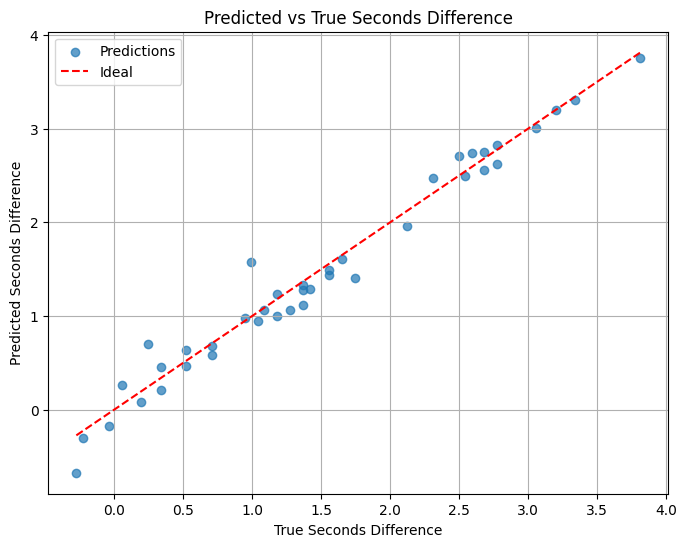

this plot displays the predicted vs true seconds difference for the test set.


In [ ]:
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        outputs = model(x)  # shape: (batch_size, num_targets)
        all_preds.append(outputs.cpu())
        all_labels.append(y.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# For plotting, we select one target column.
# In our case, target_cols = ["isgoal_1", "seconds_difference", "action_type_0"]
# Let's use "seconds_difference" (index 1) for the plot.
preds_target = all_preds[:, 1].numpy()
labels_target = all_labels[:, 1].numpy()

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(labels_target, preds_target, alpha=0.7, label="Predictions")
plt.plot([labels_target.min(), labels_target.max()],
         [labels_target.min(), labels_target.max()],
         color="red", linestyle="--", label="Ideal")
plt.xlabel("True Seconds Difference")
plt.ylabel("Predicted Seconds Difference")
plt.title("Predicted vs True Seconds Difference")
plt.legend()
plt.grid(True)
plt.show()


In [293]:
complexDf.head()

,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,action_type,result,bodypart,prev_team_id,next_team_id,is_new_possession,possession_group,possession_change,rows_in_possession_group,seconds_difference,action_distance,start_with_ball,ballmovedirection,isgoal,sequenceisgoal,actionstartpitch,possessiongroupactionstartpitch,ispossessioninteampitch
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,60gs7lod7de72ypcs6qfup8q2,8y3iucyxguipljcmf87a11bk9,52.500,34.000,43.365,36.312,0,1,0,None,8y3iucyxguipljcmf87a11bk9,1,1,No Change,1,0.0,9.135,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,43.365,36.312,48.720,34.680,21,1,0,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,0,1,No Change,2,0.5,5.355,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,48.720,34.680,45.150,50.184,0,1,0,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,0,1,No Change,3,1.0,3.570,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,8fs5klbsyx06c5ds9s1i3xu96,8y3iucyxguipljcmf87a11bk9,46.200,48.008,39.270,63.376,0,1,0,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,0,1,No Change,4,4.0,6.930,LEFT_SIDE,FORWARD,0,0,MIDDLE,MIDDLE,2
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,39.270,63.376,42.945,63.920,21,1,0,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,0,1,No Change,5,5.0,3.675,LEFT_SIDE,BACKWARD,0,0,MIDDLE,MIDDLE,2
